## Computer Vision Assignment 2
### Alex Sung-Min Hong

### 1. Dataset
THe dataset is retrieved from 'The German Traffic Sign Recognition Benchmark'([link](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news)) and consists of 51,840 images (training: 35,339, validation: 3,870, and testing: 12,631) 

### 2. Previous Attempts

1. Changed the channel size from 10 and 20 to 16 and 32 respectively. As the channel increases, the result got improved as well. Code as below.

```
class Net1(nn.Module):
    """
    change the channel size to 16 and 32
    """
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(32*5*5, 50)
        self.fc2 = nn.Linear(50, nclasses)


    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


```

2. Instead of using 5 by 5 filter twice, 3 by 3 filter has been implemented. As padding is zero and stride is one, convolution layers with a pair of 3 by 3 filter have same spatial dimension as one convolutional layer with 5 by 5 filter. This attempt results in 95+ accuracy on test data.

```
class Net2(nn.Module):
    """
    Increase the depth on top of Net1 (bigger channel)
    keep the spatial size as reduce the kernel size to 3
    """
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(128*5*5, 86)
        self.fc2 = nn.Linear(86, nclasses)

    def forward(self, x):
        x = F.relu(self.conv1(x),2)
        x = F.relu(F.max_pool2d(self.conv2(x),2))
        x = F.relu(self.conv3(x),2)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)),2))
        x = x.view(-1, 128*5*5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

3. Spatial Transfer Network (STN) is applied to the model. Before going into the convolutional neural network, STN is called and the input is transformed. 

Original paper by Jaderberg at al. (https://arxiv.org/abs/1506.02025)

Code referenced from PyTorch tutorial (https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html)


```
class Net3(nn.Module):
    """
    Spatial Transformer Network (STN) applied
    """
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1152, 50)
        self.fc2 = nn.Linear(50, nclasses)

        # localisation net
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True) # the ouput would be 10 * 3 * 3
        )

        # regressor for 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10*4*4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3*2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4) # should change the param
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 1152)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
      
```

4. Previous STN implementation did not work well (result is worse than Net2). 

Batch Normalization is applied. Fixed structure of the convolutional layers as 3 by 3 filter worked well previously.

Batch Normalization original paper by Ioffe & Szegedy (https://arxiv.org/abs/1502.03167)

```
class Net4(nn.Module):
    """
    Spatial Transformer Network (STN) applied
    Batch Normalization also applied
    Fixed the structure of convolutional layers
    """
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 64, kernel_size= 3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size= 3)
        self.conv4_drop = nn.Dropout2d()

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(128* 5 * 5, 100)
        self.fc2 = nn.Linear(100, nclasses)

        # localisation net
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True) # the ouput would be 10 * 3 * 3
        )

        # regressor for 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10*4*4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3*2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4 * 4) # should change the param
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        x = self.stn(x)

        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.bn2(x)
        x = F.relu(self.conv3(x),2)
        x = self.bn3(x)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)),2))
        #print(x.shape)
        x = x.view(-1, 128 * 5 *5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
        
```

5. Refactored STN as previous implementation did not cover the input properly (32 -> 26 -> 13 -> 9 -> 4; last column and row seems to be dropped) New design covers entire input. This model resulted in 98% in test accuracy.

```
class Net5(nn.Module):
    """
    Spatial Transformer Network (STN) fixed on top of Net4
    Jaderberg at al (https://arxiv.org/abs/1506.02025)
    """
    def __init__(self):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 64, kernel_size= 3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size= 3)
        self.conv4_drop = nn.Dropout2d()

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

        self.fc1 = nn.Linear(128 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, nclasses)

        # localisation net
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True) # the ouput would be 10 * 5 * 5
        )

        # regressor for 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10*5*5, 32),
            nn.ReLU(True),
            nn.Linear(32, 3*2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        #print(xs.shape)
        xs = xs.view(-1, 10 * 5 * 5)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        #print ("input shape", x.shape)
        x = self.stn(x)

        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.bn2(x)
        x = F.relu(self.conv3(x),2)
        x = self.bn3(x)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)),2))
        #print(x.shape)
        x = x.view(-1, 128 * 5 *5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

6. Added more layers to the model but did not performed well

```
class Net6(nn.Module):
    """
    Add more layer and use Adam optimizer
    Jaderberg at al (https://arxiv.org/abs/1506.02025)
    """
    def __init__(self):
        super(Net6, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 64, kernel_size= 3)
        self.conv3_drop = nn.Dropout2d(p=0.25)
        self.conv4 = nn.Conv2d(64, 128, kernel_size= 3)
        self.conv4_drop = nn.Dropout2d()

        #self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128* 2 * 2, 100)
        self.fc2 = nn.Linear(100, nclasses)

        # localisation net
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True) # the ouput would be 10 * 5 * 5
        )

        # regressor for 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10*5*5, 32),
            nn.ReLU(True),
            nn.Linear(32, 3*2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        #print(xs.shape)
        xs = xs.view(-1, 10 * 5 * 5)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        #print ("input shape", x.shape)
        x = self.stn(x)

        x = F.relu(self.conv1(x))
        #x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.bn2(x)
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = self.bn3(x)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)), 2))
        x = self.bn4(x)
        #print(x.shape)
        x = x.view(-1, 128 * 2 *2)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

7. Changed the STN structure and increased the input to 64 by 64, but it also did not performed well

```
class Net7(nn.Module):
    """
    Spatial Transformer Network (STN) fixed on top of Net4
    Jaderberg at al (https://arxiv.org/abs/1506.02025)
    As Net6 does not work better, keep the structure but change the STN and increase the input to 64 * 64

    """
    def __init__(self):
        super(Net7, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 64, kernel_size= 3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size= 3)
        self.conv4_drop = nn.Dropout2d()
        self.conv5 = nn.Conv2d(128, 256, kernel_size= 4)
        self.conv5_drop = nn.Dropout2d()

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, nclasses)

        # localisation net
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(10, 12, kernel_size=6),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True) # the ouput would be 10 * 5 * 5
        )

        # regressor for 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(12*4*4, 64),
            nn.ReLU(True),
            nn.Linear(64, 3*2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        #print(xs.shape)
        xs = xs.view(-1, 12 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # print ("input shape", x.shape)
        x = self.stn(x)

        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.bn2(x)
        x = F.relu(self.conv3(x), 2)
        x = self.bn3(x)
        x = F.relu(F.max_pool2d(self.conv4_drop(self.conv4(x)), 2))
        x = self.bn4(x)
        x = F.relu(F.max_pool2d(self.conv5_drop(self.conv5(x)), 2))
        x = self.bn5(x)
        #print(x.shape)
        x = x.view(-1, 256 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
```

8. After practiced the best model below, I have tried additional experiment with reduced layer. (As larger layers did not necessarily performed better, it motivated me to reduce one layer.) However, the performance was not improved and the difference was negligible.

```
class Net9(nn.Module):
    """
    Decreased the number of layer to 3.
    The performance difference compared to Net8 was negligible and lower, should not adopt this model.
    """
    def __init__(self):
        super(Net9, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 64, kernel_size= 5)
        self.conv3_drop = nn.Dropout2d()

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        #self.bn4 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(64 * 5 * 5, 100)
        self.fc2 = nn.Linear(100, nclasses)

        # localisation net
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True) # the ouput would be 10 * 5 * 5
        )

        # regressor for 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10*5*5, 32),
            nn.ReLU(True),
            nn.Linear(32, 3*2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        #print(xs.shape)
        xs = xs.view(-1, 10 * 5 * 5)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        #print ("input shape", x.shape)
        x = self.stn(x)

        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.bn2(x)
        #x = F.relu(self.conv3(x), 2)
        #x = self.bn3(x)
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        x = self.bn3(x)
        #print(x.shape)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
        
```

### 3. Best model and experiment cells

As Net5 has performed pretty good, I deviated from the model by adding more batch normalization and decreased the learning rate. It consistantly performed better and gave the best result of 99% on test data.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
print(torch.__version__)

1.2.0


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [9]:
args_batch_size = 64
epochs = 50

In [5]:
### Data Initialization and Loading
from data import initialize_data, data_transforms # data.py in the same folder
initialize_data('data') # extracts the zip files, makes a validation set from directory name data

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('data' + '/train_images',
                         transform=data_transforms),
    batch_size=args_batch_size, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('data' + '/val_images',
                         transform=data_transforms),
    batch_size=args_batch_size, shuffle=False, num_workers=1)

In [6]:
args_momentum = 0.5
args_lr = 0.00005
args_log_interval = 10

In [7]:
### Neural Network and Optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
import model as md
model = md.Net8().to(device)

In [8]:
#optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
# try adam
optimizer = optim.Adam(model.parameters(), lr=args_lr)

In [10]:
tr_loss = []
vl_loss = []

In [11]:
def train(epoch):
    model.train()
    
    training_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        training_loss +=F.nll_loss(output, target, reduction='sum').item() 
        loss.backward()
        optimizer.step()
        if batch_idx % args_log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    training_loss /= len(train_loader.dataset)
    tr_loss.append(training_loss)
    print(tr_loss)

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            #data, target = Variable(data, volatile=True), Variable(target)
            data, target = Variable(data).to(device), Variable(target)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        validation_loss /= len(val_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            validation_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))
        vl_loss.append(validation_loss)

In [12]:
for epoch in range(1, epochs + 1):
    train(epoch)
    validation()
    model_file = 'model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('\nSaved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file')

Train Epoch: 1 [0/35339 (0%)]	Loss: 3.827001
Train Epoch: 1 [640/35339 (2%)]	Loss: 3.693872
Train Epoch: 1 [1280/35339 (4%)]	Loss: 3.770112
Train Epoch: 1 [1920/35339 (5%)]	Loss: 3.698406
Train Epoch: 1 [2560/35339 (7%)]	Loss: 3.695003
Train Epoch: 1 [3200/35339 (9%)]	Loss: 3.749266
Train Epoch: 1 [3840/35339 (11%)]	Loss: 3.707747
Train Epoch: 1 [4480/35339 (13%)]	Loss: 3.668959
Train Epoch: 1 [5120/35339 (14%)]	Loss: 3.584827
Train Epoch: 1 [5760/35339 (16%)]	Loss: 3.639751
Train Epoch: 1 [6400/35339 (18%)]	Loss: 3.566101
Train Epoch: 1 [7040/35339 (20%)]	Loss: 3.535251
Train Epoch: 1 [7680/35339 (22%)]	Loss: 3.546551
Train Epoch: 1 [8320/35339 (24%)]	Loss: 3.512282
Train Epoch: 1 [8960/35339 (25%)]	Loss: 3.368645
Train Epoch: 1 [9600/35339 (27%)]	Loss: 3.438178
Train Epoch: 1 [10240/35339 (29%)]	Loss: 3.498096
Train Epoch: 1 [10880/35339 (31%)]	Loss: 3.471340
Train Epoch: 1 [11520/35339 (33%)]	Loss: 3.430654
Train Epoch: 1 [12160/35339 (34%)]	Loss: 3.218178
Train Epoch: 1 [12800/3533

Train Epoch: 3 [28800/35339 (81%)]	Loss: 1.229742
Train Epoch: 3 [29440/35339 (83%)]	Loss: 1.383513
Train Epoch: 3 [30080/35339 (85%)]	Loss: 1.341902
Train Epoch: 3 [30720/35339 (87%)]	Loss: 1.683452
Train Epoch: 3 [31360/35339 (89%)]	Loss: 1.593009
Train Epoch: 3 [32000/35339 (90%)]	Loss: 1.485039
Train Epoch: 3 [32640/35339 (92%)]	Loss: 1.253621
Train Epoch: 3 [33280/35339 (94%)]	Loss: 1.292182
Train Epoch: 3 [33920/35339 (96%)]	Loss: 1.006316
Train Epoch: 3 [34560/35339 (98%)]	Loss: 1.170638
Train Epoch: 3 [35200/35339 (99%)]	Loss: 1.506233
[3.102377717990638, 2.071347001716214, 1.5037945944079756]

Validation set: Average loss: 1.9270, Accuracy: 1776/3870 (45%)


Saved model to model_3.pth. You can run `python evaluate.py --model model_3.pth` to generate the Kaggle formatted csv file
Train Epoch: 4 [0/35339 (0%)]	Loss: 1.059479
Train Epoch: 4 [640/35339 (2%)]	Loss: 1.133558
Train Epoch: 4 [1280/35339 (4%)]	Loss: 1.124806
Train Epoch: 4 [1920/35339 (5%)]	Loss: 1.437178
Train Epoch: 

Train Epoch: 6 [17280/35339 (49%)]	Loss: 0.478447
Train Epoch: 6 [17920/35339 (51%)]	Loss: 0.661947
Train Epoch: 6 [18560/35339 (52%)]	Loss: 0.665121
Train Epoch: 6 [19200/35339 (54%)]	Loss: 0.485881
Train Epoch: 6 [19840/35339 (56%)]	Loss: 0.436143
Train Epoch: 6 [20480/35339 (58%)]	Loss: 0.647636
Train Epoch: 6 [21120/35339 (60%)]	Loss: 0.470433
Train Epoch: 6 [21760/35339 (61%)]	Loss: 0.484919
Train Epoch: 6 [22400/35339 (63%)]	Loss: 0.501897
Train Epoch: 6 [23040/35339 (65%)]	Loss: 0.520076
Train Epoch: 6 [23680/35339 (67%)]	Loss: 0.778716
Train Epoch: 6 [24320/35339 (69%)]	Loss: 0.562139
Train Epoch: 6 [24960/35339 (71%)]	Loss: 0.750760
Train Epoch: 6 [25600/35339 (72%)]	Loss: 0.349167
Train Epoch: 6 [26240/35339 (74%)]	Loss: 0.399917
Train Epoch: 6 [26880/35339 (76%)]	Loss: 0.517313
Train Epoch: 6 [27520/35339 (78%)]	Loss: 0.735927
Train Epoch: 6 [28160/35339 (80%)]	Loss: 0.395849
Train Epoch: 6 [28800/35339 (81%)]	Loss: 0.530415
Train Epoch: 6 [29440/35339 (83%)]	Loss: 0.548902


Train Epoch: 9 [3200/35339 (9%)]	Loss: 0.289420
Train Epoch: 9 [3840/35339 (11%)]	Loss: 0.427005
Train Epoch: 9 [4480/35339 (13%)]	Loss: 0.154778
Train Epoch: 9 [5120/35339 (14%)]	Loss: 0.224686
Train Epoch: 9 [5760/35339 (16%)]	Loss: 0.218929
Train Epoch: 9 [6400/35339 (18%)]	Loss: 0.154489
Train Epoch: 9 [7040/35339 (20%)]	Loss: 0.252294
Train Epoch: 9 [7680/35339 (22%)]	Loss: 0.175159
Train Epoch: 9 [8320/35339 (24%)]	Loss: 0.284279
Train Epoch: 9 [8960/35339 (25%)]	Loss: 0.155297
Train Epoch: 9 [9600/35339 (27%)]	Loss: 0.188603
Train Epoch: 9 [10240/35339 (29%)]	Loss: 0.237959
Train Epoch: 9 [10880/35339 (31%)]	Loss: 0.402769
Train Epoch: 9 [11520/35339 (33%)]	Loss: 0.373622
Train Epoch: 9 [12160/35339 (34%)]	Loss: 0.253210
Train Epoch: 9 [12800/35339 (36%)]	Loss: 0.236390
Train Epoch: 9 [13440/35339 (38%)]	Loss: 0.254019
Train Epoch: 9 [14080/35339 (40%)]	Loss: 0.204371
Train Epoch: 9 [14720/35339 (42%)]	Loss: 0.284490
Train Epoch: 9 [15360/35339 (43%)]	Loss: 0.372114
Train Epoch:

Train Epoch: 11 [26880/35339 (76%)]	Loss: 0.082344
Train Epoch: 11 [27520/35339 (78%)]	Loss: 0.146776
Train Epoch: 11 [28160/35339 (80%)]	Loss: 0.114119
Train Epoch: 11 [28800/35339 (81%)]	Loss: 0.095363
Train Epoch: 11 [29440/35339 (83%)]	Loss: 0.125425
Train Epoch: 11 [30080/35339 (85%)]	Loss: 0.236601
Train Epoch: 11 [30720/35339 (87%)]	Loss: 0.098542
Train Epoch: 11 [31360/35339 (89%)]	Loss: 0.080527
Train Epoch: 11 [32000/35339 (90%)]	Loss: 0.229361
Train Epoch: 11 [32640/35339 (92%)]	Loss: 0.247314
Train Epoch: 11 [33280/35339 (94%)]	Loss: 0.186038
Train Epoch: 11 [33920/35339 (96%)]	Loss: 0.107934
Train Epoch: 11 [34560/35339 (98%)]	Loss: 0.079044
Train Epoch: 11 [35200/35339 (99%)]	Loss: 0.248854
[3.102377717990638, 2.071347001716214, 1.5037945944079756, 1.0704973123889852, 0.76225177265967, 0.5503446137265204, 0.41025832676348456, 0.3177498570220938, 0.2507866959528795, 0.20070912016059106, 0.1649287866967222]

Validation set: Average loss: 0.2167, Accuracy: 3651/3870 (94%)




Train Epoch: 14 [7040/35339 (20%)]	Loss: 0.093211
Train Epoch: 14 [7680/35339 (22%)]	Loss: 0.058083
Train Epoch: 14 [8320/35339 (24%)]	Loss: 0.180756
Train Epoch: 14 [8960/35339 (25%)]	Loss: 0.123851
Train Epoch: 14 [9600/35339 (27%)]	Loss: 0.103978
Train Epoch: 14 [10240/35339 (29%)]	Loss: 0.167776
Train Epoch: 14 [10880/35339 (31%)]	Loss: 0.094076
Train Epoch: 14 [11520/35339 (33%)]	Loss: 0.069046
Train Epoch: 14 [12160/35339 (34%)]	Loss: 0.068058
Train Epoch: 14 [12800/35339 (36%)]	Loss: 0.098603
Train Epoch: 14 [13440/35339 (38%)]	Loss: 0.104943
Train Epoch: 14 [14080/35339 (40%)]	Loss: 0.075905
Train Epoch: 14 [14720/35339 (42%)]	Loss: 0.064744
Train Epoch: 14 [15360/35339 (43%)]	Loss: 0.061363
Train Epoch: 14 [16000/35339 (45%)]	Loss: 0.088537
Train Epoch: 14 [16640/35339 (47%)]	Loss: 0.142999
Train Epoch: 14 [17280/35339 (49%)]	Loss: 0.154888
Train Epoch: 14 [17920/35339 (51%)]	Loss: 0.143198
Train Epoch: 14 [18560/35339 (52%)]	Loss: 0.154084
Train Epoch: 14 [19200/35339 (54%)]	

Train Epoch: 16 [26880/35339 (76%)]	Loss: 0.038275
Train Epoch: 16 [27520/35339 (78%)]	Loss: 0.035300
Train Epoch: 16 [28160/35339 (80%)]	Loss: 0.046934
Train Epoch: 16 [28800/35339 (81%)]	Loss: 0.070794
Train Epoch: 16 [29440/35339 (83%)]	Loss: 0.058381
Train Epoch: 16 [30080/35339 (85%)]	Loss: 0.086394
Train Epoch: 16 [30720/35339 (87%)]	Loss: 0.052264
Train Epoch: 16 [31360/35339 (89%)]	Loss: 0.097772
Train Epoch: 16 [32000/35339 (90%)]	Loss: 0.121461
Train Epoch: 16 [32640/35339 (92%)]	Loss: 0.044286
Train Epoch: 16 [33280/35339 (94%)]	Loss: 0.062595
Train Epoch: 16 [33920/35339 (96%)]	Loss: 0.041394
Train Epoch: 16 [34560/35339 (98%)]	Loss: 0.088773
Train Epoch: 16 [35200/35339 (99%)]	Loss: 0.109648
[3.102377717990638, 2.071347001716214, 1.5037945944079756, 1.0704973123889852, 0.76225177265967, 0.5503446137265204, 0.41025832676348456, 0.3177498570220938, 0.2507866959528795, 0.20070912016059106, 0.1649287866967222, 0.14192475876286922, 0.11832947289317272, 0.10353662295111972, 0.09

Train Epoch: 19 [3200/35339 (9%)]	Loss: 0.054223
Train Epoch: 19 [3840/35339 (11%)]	Loss: 0.056141
Train Epoch: 19 [4480/35339 (13%)]	Loss: 0.042471
Train Epoch: 19 [5120/35339 (14%)]	Loss: 0.078312
Train Epoch: 19 [5760/35339 (16%)]	Loss: 0.049148
Train Epoch: 19 [6400/35339 (18%)]	Loss: 0.053511
Train Epoch: 19 [7040/35339 (20%)]	Loss: 0.024859
Train Epoch: 19 [7680/35339 (22%)]	Loss: 0.124384
Train Epoch: 19 [8320/35339 (24%)]	Loss: 0.060781
Train Epoch: 19 [8960/35339 (25%)]	Loss: 0.010855
Train Epoch: 19 [9600/35339 (27%)]	Loss: 0.091986
Train Epoch: 19 [10240/35339 (29%)]	Loss: 0.069848
Train Epoch: 19 [10880/35339 (31%)]	Loss: 0.028159
Train Epoch: 19 [11520/35339 (33%)]	Loss: 0.032693
Train Epoch: 19 [12160/35339 (34%)]	Loss: 0.138150
Train Epoch: 19 [12800/35339 (36%)]	Loss: 0.087054
Train Epoch: 19 [13440/35339 (38%)]	Loss: 0.024087
Train Epoch: 19 [14080/35339 (40%)]	Loss: 0.015719
Train Epoch: 19 [14720/35339 (42%)]	Loss: 0.049438
Train Epoch: 19 [15360/35339 (43%)]	Loss: 0

Train Epoch: 21 [20480/35339 (58%)]	Loss: 0.039746
Train Epoch: 21 [21120/35339 (60%)]	Loss: 0.150658
Train Epoch: 21 [21760/35339 (61%)]	Loss: 0.020267
Train Epoch: 21 [22400/35339 (63%)]	Loss: 0.073848
Train Epoch: 21 [23040/35339 (65%)]	Loss: 0.031423
Train Epoch: 21 [23680/35339 (67%)]	Loss: 0.039112
Train Epoch: 21 [24320/35339 (69%)]	Loss: 0.012565
Train Epoch: 21 [24960/35339 (71%)]	Loss: 0.046494
Train Epoch: 21 [25600/35339 (72%)]	Loss: 0.026321
Train Epoch: 21 [26240/35339 (74%)]	Loss: 0.058297
Train Epoch: 21 [26880/35339 (76%)]	Loss: 0.074590
Train Epoch: 21 [27520/35339 (78%)]	Loss: 0.055739
Train Epoch: 21 [28160/35339 (80%)]	Loss: 0.028672
Train Epoch: 21 [28800/35339 (81%)]	Loss: 0.081830
Train Epoch: 21 [29440/35339 (83%)]	Loss: 0.073461
Train Epoch: 21 [30080/35339 (85%)]	Loss: 0.046075
Train Epoch: 21 [30720/35339 (87%)]	Loss: 0.033200
Train Epoch: 21 [31360/35339 (89%)]	Loss: 0.126849
Train Epoch: 21 [32000/35339 (90%)]	Loss: 0.015807
Train Epoch: 21 [32640/35339 (9


Validation set: Average loss: 0.0983, Accuracy: 3754/3870 (97%)


Saved model to model_23.pth. You can run `python evaluate.py --model model_23.pth` to generate the Kaggle formatted csv file
Train Epoch: 24 [0/35339 (0%)]	Loss: 0.045020
Train Epoch: 24 [640/35339 (2%)]	Loss: 0.051743
Train Epoch: 24 [1280/35339 (4%)]	Loss: 0.011127
Train Epoch: 24 [1920/35339 (5%)]	Loss: 0.070408
Train Epoch: 24 [2560/35339 (7%)]	Loss: 0.007859
Train Epoch: 24 [3200/35339 (9%)]	Loss: 0.014553
Train Epoch: 24 [3840/35339 (11%)]	Loss: 0.046031
Train Epoch: 24 [4480/35339 (13%)]	Loss: 0.040173
Train Epoch: 24 [5120/35339 (14%)]	Loss: 0.021716
Train Epoch: 24 [5760/35339 (16%)]	Loss: 0.014683
Train Epoch: 24 [6400/35339 (18%)]	Loss: 0.062731
Train Epoch: 24 [7040/35339 (20%)]	Loss: 0.039238
Train Epoch: 24 [7680/35339 (22%)]	Loss: 0.016816
Train Epoch: 24 [8320/35339 (24%)]	Loss: 0.034634
Train Epoch: 24 [8960/35339 (25%)]	Loss: 0.179131
Train Epoch: 24 [9600/35339 (27%)]	Loss: 0.005354
Train Epoch: 24 [1

Train Epoch: 26 [12800/35339 (36%)]	Loss: 0.059496
Train Epoch: 26 [13440/35339 (38%)]	Loss: 0.049457
Train Epoch: 26 [14080/35339 (40%)]	Loss: 0.003044
Train Epoch: 26 [14720/35339 (42%)]	Loss: 0.026072
Train Epoch: 26 [15360/35339 (43%)]	Loss: 0.010721
Train Epoch: 26 [16000/35339 (45%)]	Loss: 0.008508
Train Epoch: 26 [16640/35339 (47%)]	Loss: 0.027196
Train Epoch: 26 [17280/35339 (49%)]	Loss: 0.024855
Train Epoch: 26 [17920/35339 (51%)]	Loss: 0.004811
Train Epoch: 26 [18560/35339 (52%)]	Loss: 0.013950
Train Epoch: 26 [19200/35339 (54%)]	Loss: 0.052285
Train Epoch: 26 [19840/35339 (56%)]	Loss: 0.024002
Train Epoch: 26 [20480/35339 (58%)]	Loss: 0.028273
Train Epoch: 26 [21120/35339 (60%)]	Loss: 0.027848
Train Epoch: 26 [21760/35339 (61%)]	Loss: 0.025608
Train Epoch: 26 [22400/35339 (63%)]	Loss: 0.042300
Train Epoch: 26 [23040/35339 (65%)]	Loss: 0.025831
Train Epoch: 26 [23680/35339 (67%)]	Loss: 0.002363
Train Epoch: 26 [24320/35339 (69%)]	Loss: 0.018052
Train Epoch: 26 [24960/35339 (7

Train Epoch: 28 [26240/35339 (74%)]	Loss: 0.082387
Train Epoch: 28 [26880/35339 (76%)]	Loss: 0.010873
Train Epoch: 28 [27520/35339 (78%)]	Loss: 0.008574
Train Epoch: 28 [28160/35339 (80%)]	Loss: 0.027441
Train Epoch: 28 [28800/35339 (81%)]	Loss: 0.002848
Train Epoch: 28 [29440/35339 (83%)]	Loss: 0.039550
Train Epoch: 28 [30080/35339 (85%)]	Loss: 0.049065
Train Epoch: 28 [30720/35339 (87%)]	Loss: 0.004342
Train Epoch: 28 [31360/35339 (89%)]	Loss: 0.011524
Train Epoch: 28 [32000/35339 (90%)]	Loss: 0.008653
Train Epoch: 28 [32640/35339 (92%)]	Loss: 0.033409
Train Epoch: 28 [33280/35339 (94%)]	Loss: 0.012921
Train Epoch: 28 [33920/35339 (96%)]	Loss: 0.003922
Train Epoch: 28 [34560/35339 (98%)]	Loss: 0.002843
Train Epoch: 28 [35200/35339 (99%)]	Loss: 0.021247
[3.102377717990638, 2.071347001716214, 1.5037945944079756, 1.0704973123889852, 0.76225177265967, 0.5503446137265204, 0.41025832676348456, 0.3177498570220938, 0.2507866959528795, 0.20070912016059106, 0.1649287866967222, 0.14192475876286


Validation set: Average loss: 0.0748, Accuracy: 3789/3870 (97%)


Saved model to model_30.pth. You can run `python evaluate.py --model model_30.pth` to generate the Kaggle formatted csv file
Train Epoch: 31 [0/35339 (0%)]	Loss: 0.025700
Train Epoch: 31 [640/35339 (2%)]	Loss: 0.021520
Train Epoch: 31 [1280/35339 (4%)]	Loss: 0.037687
Train Epoch: 31 [1920/35339 (5%)]	Loss: 0.007013
Train Epoch: 31 [2560/35339 (7%)]	Loss: 0.020161
Train Epoch: 31 [3200/35339 (9%)]	Loss: 0.012820
Train Epoch: 31 [3840/35339 (11%)]	Loss: 0.030059
Train Epoch: 31 [4480/35339 (13%)]	Loss: 0.005145
Train Epoch: 31 [5120/35339 (14%)]	Loss: 0.017325
Train Epoch: 31 [5760/35339 (16%)]	Loss: 0.005678
Train Epoch: 31 [6400/35339 (18%)]	Loss: 0.010235
Train Epoch: 31 [7040/35339 (20%)]	Loss: 0.043424
Train Epoch: 31 [7680/35339 (22%)]	Loss: 0.014073
Train Epoch: 31 [8320/35339 (24%)]	Loss: 0.071902
Train Epoch: 31 [8960/35339 (25%)]	Loss: 0.026523
Train Epoch: 31 [9600/35339 (27%)]	Loss: 0.013166
Train Epoch: 31 [1

Train Epoch: 33 [8960/35339 (25%)]	Loss: 0.035258
Train Epoch: 33 [9600/35339 (27%)]	Loss: 0.039241
Train Epoch: 33 [10240/35339 (29%)]	Loss: 0.006932
Train Epoch: 33 [10880/35339 (31%)]	Loss: 0.103116
Train Epoch: 33 [11520/35339 (33%)]	Loss: 0.004205
Train Epoch: 33 [12160/35339 (34%)]	Loss: 0.017103
Train Epoch: 33 [12800/35339 (36%)]	Loss: 0.003144
Train Epoch: 33 [13440/35339 (38%)]	Loss: 0.010650
Train Epoch: 33 [14080/35339 (40%)]	Loss: 0.009579
Train Epoch: 33 [14720/35339 (42%)]	Loss: 0.003310
Train Epoch: 33 [15360/35339 (43%)]	Loss: 0.001007
Train Epoch: 33 [16000/35339 (45%)]	Loss: 0.016019
Train Epoch: 33 [16640/35339 (47%)]	Loss: 0.009960
Train Epoch: 33 [17280/35339 (49%)]	Loss: 0.032255
Train Epoch: 33 [17920/35339 (51%)]	Loss: 0.037640
Train Epoch: 33 [18560/35339 (52%)]	Loss: 0.009044
Train Epoch: 33 [19200/35339 (54%)]	Loss: 0.010249
Train Epoch: 33 [19840/35339 (56%)]	Loss: 0.014268
Train Epoch: 33 [20480/35339 (58%)]	Loss: 0.014560
Train Epoch: 33 [21120/35339 (60%

Train Epoch: 35 [18560/35339 (52%)]	Loss: 0.010681
Train Epoch: 35 [19200/35339 (54%)]	Loss: 0.036935
Train Epoch: 35 [19840/35339 (56%)]	Loss: 0.006884
Train Epoch: 35 [20480/35339 (58%)]	Loss: 0.011032
Train Epoch: 35 [21120/35339 (60%)]	Loss: 0.018060
Train Epoch: 35 [21760/35339 (61%)]	Loss: 0.027404
Train Epoch: 35 [22400/35339 (63%)]	Loss: 0.027916
Train Epoch: 35 [23040/35339 (65%)]	Loss: 0.006134
Train Epoch: 35 [23680/35339 (67%)]	Loss: 0.017299
Train Epoch: 35 [24320/35339 (69%)]	Loss: 0.019942
Train Epoch: 35 [24960/35339 (71%)]	Loss: 0.033088
Train Epoch: 35 [25600/35339 (72%)]	Loss: 0.010095
Train Epoch: 35 [26240/35339 (74%)]	Loss: 0.010566
Train Epoch: 35 [26880/35339 (76%)]	Loss: 0.038665
Train Epoch: 35 [27520/35339 (78%)]	Loss: 0.003540
Train Epoch: 35 [28160/35339 (80%)]	Loss: 0.005600
Train Epoch: 35 [28800/35339 (81%)]	Loss: 0.004993
Train Epoch: 35 [29440/35339 (83%)]	Loss: 0.011781
Train Epoch: 35 [30080/35339 (85%)]	Loss: 0.010550
Train Epoch: 35 [30720/35339 (8

Train Epoch: 37 [26880/35339 (76%)]	Loss: 0.017137
Train Epoch: 37 [27520/35339 (78%)]	Loss: 0.008544
Train Epoch: 37 [28160/35339 (80%)]	Loss: 0.019984
Train Epoch: 37 [28800/35339 (81%)]	Loss: 0.005719
Train Epoch: 37 [29440/35339 (83%)]	Loss: 0.039189
Train Epoch: 37 [30080/35339 (85%)]	Loss: 0.003337
Train Epoch: 37 [30720/35339 (87%)]	Loss: 0.009615
Train Epoch: 37 [31360/35339 (89%)]	Loss: 0.009472
Train Epoch: 37 [32000/35339 (90%)]	Loss: 0.005736
Train Epoch: 37 [32640/35339 (92%)]	Loss: 0.054822
Train Epoch: 37 [33280/35339 (94%)]	Loss: 0.013617
Train Epoch: 37 [33920/35339 (96%)]	Loss: 0.020510
Train Epoch: 37 [34560/35339 (98%)]	Loss: 0.049923
Train Epoch: 37 [35200/35339 (99%)]	Loss: 0.006851
[3.102377717990638, 2.071347001716214, 1.5037945944079756, 1.0704973123889852, 0.76225177265967, 0.5503446137265204, 0.41025832676348456, 0.3177498570220938, 0.2507866959528795, 0.20070912016059106, 0.1649287866967222, 0.14192475876286922, 0.11832947289317272, 0.10353662295111972, 0.09

Train Epoch: 39 [34560/35339 (98%)]	Loss: 0.009818
Train Epoch: 39 [35200/35339 (99%)]	Loss: 0.006877
[3.102377717990638, 2.071347001716214, 1.5037945944079756, 1.0704973123889852, 0.76225177265967, 0.5503446137265204, 0.41025832676348456, 0.3177498570220938, 0.2507866959528795, 0.20070912016059106, 0.1649287866967222, 0.14192475876286922, 0.11832947289317272, 0.10353662295111972, 0.09071767668681016, 0.07858081307765964, 0.06870077818989696, 0.06336045814372103, 0.05893281313012157, 0.05508962009383461, 0.04948997359168682, 0.04589421097341514, 0.042241091750444756, 0.03705221842976006, 0.034021724507028374, 0.03275277341549619, 0.02923009503783423, 0.029069132737522534, 0.027023073943718345, 0.025005043709359742, 0.025224315980556054, 0.021078614445134855, 0.02049634994145663, 0.020379190417757435, 0.019484101525040966, 0.018772132336043832, 0.018908483270157157, 0.016918381610667315, 0.017011046397273282]

Validation set: Average loss: 0.0765, Accuracy: 3789/3870 (97%)


Saved model


Validation set: Average loss: 0.0674, Accuracy: 3796/3870 (98%)


Saved model to model_41.pth. You can run `python evaluate.py --model model_41.pth` to generate the Kaggle formatted csv file
Train Epoch: 42 [0/35339 (0%)]	Loss: 0.003595
Train Epoch: 42 [640/35339 (2%)]	Loss: 0.003234
Train Epoch: 42 [1280/35339 (4%)]	Loss: 0.006918
Train Epoch: 42 [1920/35339 (5%)]	Loss: 0.013539
Train Epoch: 42 [2560/35339 (7%)]	Loss: 0.022583
Train Epoch: 42 [3200/35339 (9%)]	Loss: 0.002495
Train Epoch: 42 [3840/35339 (11%)]	Loss: 0.017702
Train Epoch: 42 [4480/35339 (13%)]	Loss: 0.063295
Train Epoch: 42 [5120/35339 (14%)]	Loss: 0.008095
Train Epoch: 42 [5760/35339 (16%)]	Loss: 0.002356
Train Epoch: 42 [6400/35339 (18%)]	Loss: 0.003849
Train Epoch: 42 [7040/35339 (20%)]	Loss: 0.011953
Train Epoch: 42 [7680/35339 (22%)]	Loss: 0.003521
Train Epoch: 42 [8320/35339 (24%)]	Loss: 0.006028
Train Epoch: 42 [8960/35339 (25%)]	Loss: 0.006656
Train Epoch: 42 [9600/35339 (27%)]	Loss: 0.009175
Train Epoch: 42 [1

Train Epoch: 44 [2560/35339 (7%)]	Loss: 0.027393
Train Epoch: 44 [3200/35339 (9%)]	Loss: 0.000512
Train Epoch: 44 [3840/35339 (11%)]	Loss: 0.001185
Train Epoch: 44 [4480/35339 (13%)]	Loss: 0.055508
Train Epoch: 44 [5120/35339 (14%)]	Loss: 0.028565
Train Epoch: 44 [5760/35339 (16%)]	Loss: 0.019198
Train Epoch: 44 [6400/35339 (18%)]	Loss: 0.012938
Train Epoch: 44 [7040/35339 (20%)]	Loss: 0.018367
Train Epoch: 44 [7680/35339 (22%)]	Loss: 0.003991
Train Epoch: 44 [8320/35339 (24%)]	Loss: 0.029958
Train Epoch: 44 [8960/35339 (25%)]	Loss: 0.001443
Train Epoch: 44 [9600/35339 (27%)]	Loss: 0.001436
Train Epoch: 44 [10240/35339 (29%)]	Loss: 0.008167
Train Epoch: 44 [10880/35339 (31%)]	Loss: 0.014676
Train Epoch: 44 [11520/35339 (33%)]	Loss: 0.003144
Train Epoch: 44 [12160/35339 (34%)]	Loss: 0.002911
Train Epoch: 44 [12800/35339 (36%)]	Loss: 0.014502
Train Epoch: 44 [13440/35339 (38%)]	Loss: 0.001502
Train Epoch: 44 [14080/35339 (40%)]	Loss: 0.011448
Train Epoch: 44 [14720/35339 (42%)]	Loss: 0.0

Train Epoch: 46 [6400/35339 (18%)]	Loss: 0.007571
Train Epoch: 46 [7040/35339 (20%)]	Loss: 0.002042
Train Epoch: 46 [7680/35339 (22%)]	Loss: 0.003307
Train Epoch: 46 [8320/35339 (24%)]	Loss: 0.008325
Train Epoch: 46 [8960/35339 (25%)]	Loss: 0.005560
Train Epoch: 46 [9600/35339 (27%)]	Loss: 0.003900
Train Epoch: 46 [10240/35339 (29%)]	Loss: 0.027428
Train Epoch: 46 [10880/35339 (31%)]	Loss: 0.004702
Train Epoch: 46 [11520/35339 (33%)]	Loss: 0.016287
Train Epoch: 46 [12160/35339 (34%)]	Loss: 0.001429
Train Epoch: 46 [12800/35339 (36%)]	Loss: 0.001678
Train Epoch: 46 [13440/35339 (38%)]	Loss: 0.009830
Train Epoch: 46 [14080/35339 (40%)]	Loss: 0.004027
Train Epoch: 46 [14720/35339 (42%)]	Loss: 0.007287
Train Epoch: 46 [15360/35339 (43%)]	Loss: 0.007837
Train Epoch: 46 [16000/35339 (45%)]	Loss: 0.016938
Train Epoch: 46 [16640/35339 (47%)]	Loss: 0.035437
Train Epoch: 46 [17280/35339 (49%)]	Loss: 0.006144
Train Epoch: 46 [17920/35339 (51%)]	Loss: 0.001298
Train Epoch: 46 [18560/35339 (52%)]	L

Train Epoch: 48 [8960/35339 (25%)]	Loss: 0.002812
Train Epoch: 48 [9600/35339 (27%)]	Loss: 0.036301
Train Epoch: 48 [10240/35339 (29%)]	Loss: 0.001324
Train Epoch: 48 [10880/35339 (31%)]	Loss: 0.002733
Train Epoch: 48 [11520/35339 (33%)]	Loss: 0.001043
Train Epoch: 48 [12160/35339 (34%)]	Loss: 0.019130
Train Epoch: 48 [12800/35339 (36%)]	Loss: 0.024919
Train Epoch: 48 [13440/35339 (38%)]	Loss: 0.000737
Train Epoch: 48 [14080/35339 (40%)]	Loss: 0.005010
Train Epoch: 48 [14720/35339 (42%)]	Loss: 0.004888
Train Epoch: 48 [15360/35339 (43%)]	Loss: 0.004319
Train Epoch: 48 [16000/35339 (45%)]	Loss: 0.029043
Train Epoch: 48 [16640/35339 (47%)]	Loss: 0.011286
Train Epoch: 48 [17280/35339 (49%)]	Loss: 0.009542
Train Epoch: 48 [17920/35339 (51%)]	Loss: 0.026234
Train Epoch: 48 [18560/35339 (52%)]	Loss: 0.002571
Train Epoch: 48 [19200/35339 (54%)]	Loss: 0.005153
Train Epoch: 48 [19840/35339 (56%)]	Loss: 0.003047
Train Epoch: 48 [20480/35339 (58%)]	Loss: 0.003433
Train Epoch: 48 [21120/35339 (60%

Train Epoch: 50 [10240/35339 (29%)]	Loss: 0.001325
Train Epoch: 50 [10880/35339 (31%)]	Loss: 0.005599
Train Epoch: 50 [11520/35339 (33%)]	Loss: 0.006520
Train Epoch: 50 [12160/35339 (34%)]	Loss: 0.014289
Train Epoch: 50 [12800/35339 (36%)]	Loss: 0.003773
Train Epoch: 50 [13440/35339 (38%)]	Loss: 0.007501
Train Epoch: 50 [14080/35339 (40%)]	Loss: 0.001584
Train Epoch: 50 [14720/35339 (42%)]	Loss: 0.027664
Train Epoch: 50 [15360/35339 (43%)]	Loss: 0.004252
Train Epoch: 50 [16000/35339 (45%)]	Loss: 0.008352
Train Epoch: 50 [16640/35339 (47%)]	Loss: 0.012156
Train Epoch: 50 [17280/35339 (49%)]	Loss: 0.003932
Train Epoch: 50 [17920/35339 (51%)]	Loss: 0.006634
Train Epoch: 50 [18560/35339 (52%)]	Loss: 0.010353
Train Epoch: 50 [19200/35339 (54%)]	Loss: 0.011689
Train Epoch: 50 [19840/35339 (56%)]	Loss: 0.002242
Train Epoch: 50 [20480/35339 (58%)]	Loss: 0.014151
Train Epoch: 50 [21120/35339 (60%)]	Loss: 0.004050
Train Epoch: 50 [21760/35339 (61%)]	Loss: 0.006284
Train Epoch: 50 [22400/35339 (6

In [13]:
import matplotlib.pyplot as plt
plt.ion()

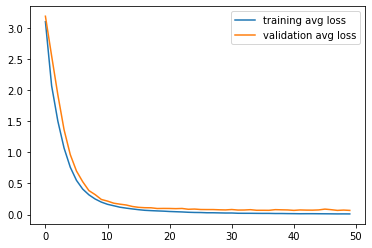

In [14]:
plt.plot(tr_loss)
plt.plot(vl_loss)
plt.legend(['training avg loss', 'validation avg loss'])
plt.show()

Best model was extracted from epoch 50.
Previously, I have trained the same model and got better accuracy in terms of number of correct instances in validation data (3797). However, this experiement result has lower average loss and performed slightly better on test data, which is 99.002% versus 98.939%.